# EDA - 1
Explore the relationship between the _sentiment in comments_ and _review scores in different aspects like description accuracy, clealiness, location, communcation, etc._

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import geopandas as gpd

In [107]:
%matplotlib inline

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [133]:
df = pd.read_csv('../../Datasets/cleaned_customer.csv').iloc[:,1:]
df.head()

,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,host_since,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,nearby_sites_rating,nearest_station_dist,nearest_site_dist,nearest_site_rating,senti_score
0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,2010-10-20,...,8.0,8.0,f,2,0.02,0.995731,0.617762,4.295315,4.595264,0.9615
1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423,0.9484
2,15222393,50646,2014-06-05,Welli,Stayed over at Sujatha's house for 3 good nigh...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423,0.9879
3,5543172,50646,2014-07-02,Cyril,It's been a lovely stay at Sujatha's. The room...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423,0.9651
4,817532,50646,2014-07-08,Jake,"We had a great experience. A nice place, an am...",Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423,0.9274


In [10]:
df.columns

Index(['reviewer_id', 'listing_id', 'date', 'reviewer_name', 'comments',
       'name', 'description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
    

In [88]:
# The sentiment scores are acquired from the previous data preparation step.
df_review = df[['senti_score','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']]

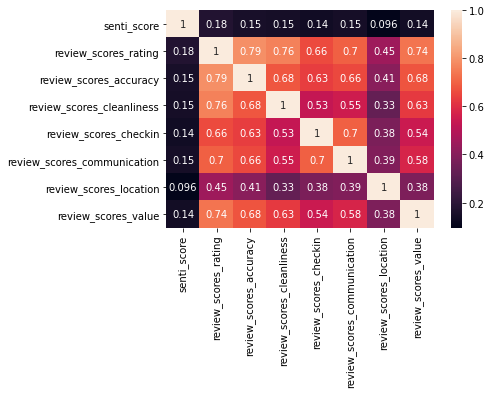

In [89]:
corrMatrix = df_review.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### It can be seen that there exists moderate correlation between sentiment score in comments and review scores, especially the review_score_rating.
The review score rating is presumed to be the overall score for the house by that reviewer. <br>
To make a more rigorous evaluation, we regressed the sentiment score on all other review scores.

In [13]:
# Utility method for linear regression and its summary.
def linear_model(X,y):
    import statsmodels.api as sm
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    print("R Squared:",est2.rsquared)

In [17]:
X = df_review.dropna().drop(['senti_score'],axis=1)
y = df_review.dropna()['senti_score']
linear_model(X,y)

                            OLS Regression Results                            
Dep. Variable:            senti_score   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     772.2
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:42:28   Log-Likelihood:                -75407.
No. Observations:              154801   AIC:                         1.508e+05
Df Residuals:                  154793   BIC:                         1.509e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

As can be seen from above, except review_score_value, **all other review scores are significantly correlated with sentiment scores**, which means all these factors **affect much** in user reviews.

#### Now we explore the correlation between review_location_score and nearby sites

In [25]:
# Extract the relevant features
df_location = df[['review_scores_location','nearby_sites_rating', 'nearest_station_dist', 'nearest_site_dist',
       'nearest_site_rating']]

`nearby_sites_rating` means the weighted average rating score for the nearest 3 sites; `nearest_site_dist` means the distance to the nesrest popular site; `nearest_site_rating` means the rating for the nearest site; `nearest_station_dist` means the distance to the nearest MRT station.

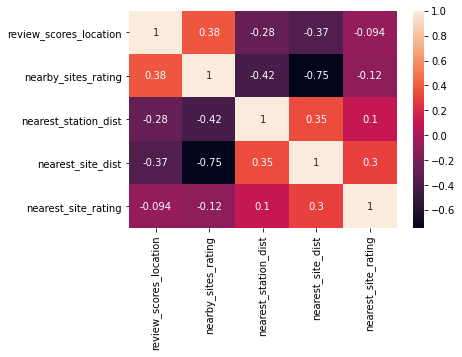

In [26]:
corrMatrix = df_location.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

As can be observed from above the `nearby site rating` is closely related to the `review score location`. And `review score location`is also negatively correlated with the `nearest site distance` and `nearest_station_dist`, which is reasonable because the further a location is to a station or a popular site, the worse its location tends to be.<br>

The conclusion is that among the factors that affect user review sentiments, `review_scores_location` plays **an insignificant role**, which means customers are **not so focused on** the location of the hotel. Specifically, the `location score` is **closely related to** the distance to nearby sites and MRT stations and the popularity of the sites.

# EDA - 5

Relationship between `Price`,`review_scores`, `sentiment_score` and `Neighbourhood_cleansed`, where `Neighbourhood_cleansed` means the summarized and cleansed version of the original neighborhood name.

In [135]:
# Transform the price attribute to numeric.
df.price = df.price.apply(lambda x:float(x.strip('$').replace(',',''))) 

In [120]:
df.price.describe()

count    155250.000000
mean        135.037546
std         138.151531
min           0.000000
25%          62.000000
50%         100.000000
75%         170.000000
max        9999.000000
Name: price, dtype: float64

As we can see from above, there are some **outliers** in price. Thus we decided to keep 99.5% of the price data for the sake of analysis.

In [136]:
df[df.price > df.price.quantile(0.995)].drop_duplicates(['listing_id']).price.describe()

count      92.000000
mean     1288.521739
std      1602.862683
min       601.000000
25%       659.750000
50%       773.000000
75%      1090.250000
max      9999.000000
Name: price, dtype: float64

In [145]:
df_cut = df[df.price <= df.price.quantile(0.995)]

In [146]:
# Extract the useful features.
df_price = df_cut[['price','senti_score','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','neighbourhood_cleansed']]

# Group all duplicate listings and keep their mean price.
df_price_nbr = df_price.groupby(['neighbourhood_cleansed']).mean()


In [147]:
df_price_nbr

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Ang Mo Kio,83.254325,0.684850,93.441901,9.580986,9.392606,9.938272,9.931338,9.035336,9.340388
Bedok,101.185028,0.674384,94.217740,9.666925,9.548358,9.795190,9.793121,9.364930,9.411742
Bishan,77.375276,0.647420,92.489433,9.450501,9.230256,9.705228,9.666296,9.219132,9.317019
Bukit Batok,73.005806,0.648054,92.387427,9.432749,9.362573,9.687683,9.796784,9.060117,9.256598
Bukit Merah,146.304147,0.656271,92.660471,9.557156,9.340458,9.720880,9.663259,9.506815,9.199969
Bukit Panjang,118.159744,0.661394,90.508039,9.302251,9.147910,9.424437,9.604502,8.982315,9.163987
Bukit Timah,89.481157,0.687605,92.716865,9.507272,9.272127,9.711767,9.758925,9.228735,9.329661
Central Water Catchment,83.296296,0.663990,93.579439,9.411215,9.308411,9.971963,9.967290,9.359813,9.299065
Changi,488.000000,0.212867,73.000000,7.000000,8.000000,7.000000,9.000000,9.000000,7.000000


In [148]:
df_price_nbr.sort_values(['senti_score'],ascending=False)[:3]

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Paya Lebar,45.000000,0.983600,60.000000,4.000000,2.000000,6.000000,10.000000,6.000000,6.000000
Southern Islands,223.177215,0.739707,96.798701,9.798701,9.857143,9.746753,9.792208,9.467532,9.337662
Sengkang,50.784215,0.719422,94.733953,9.922297,9.665541,9.789696,9.946791,8.879223,9.460304


In [197]:
df_price_nbr.sort_values(['review_scores_rating'],ascending=False)[:3]

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Western Water Catchment,42.129032,0.630119,97.074074,10.000000,10.000000,10.000000,10.000000,9.000000,9.074074
Southern Islands,223.177215,0.739707,96.798701,9.798701,9.857143,9.746753,9.792208,9.467532,9.337662
Museum,340.136825,0.646590,95.677540,9.705348,9.680214,9.874866,9.758824,9.928877,9.352406


Now we plot the price and relevant measures on the map.

In [152]:
# import our image 
singapore_img = mpimg.imread('../Pictures/sgshape.png')

In [161]:
# plot the data
def plotmap(df, attr):
    ax = df.plot(
        kind="scatter", 
        x="longitude", 
        y="latitude", 
        figsize=(20,14),
        c=attr, 
        cmap=plt.get_cmap("jet"),
        colorbar=True, 
        alpha=0.4,
    )

    plt.imshow(singapore_img, extent=[103.5,104,1.15, 1.50], alpha=0.5)            

    plt.ylabel("Latitude", fontsize=20)
    plt.xlabel("Longitude", fontsize=20)

    plt.ylim(1.15, 1.50)
    plt.xlim(103.5, 104)
    plt.title('Price Variations with Locations')
    plt.show()

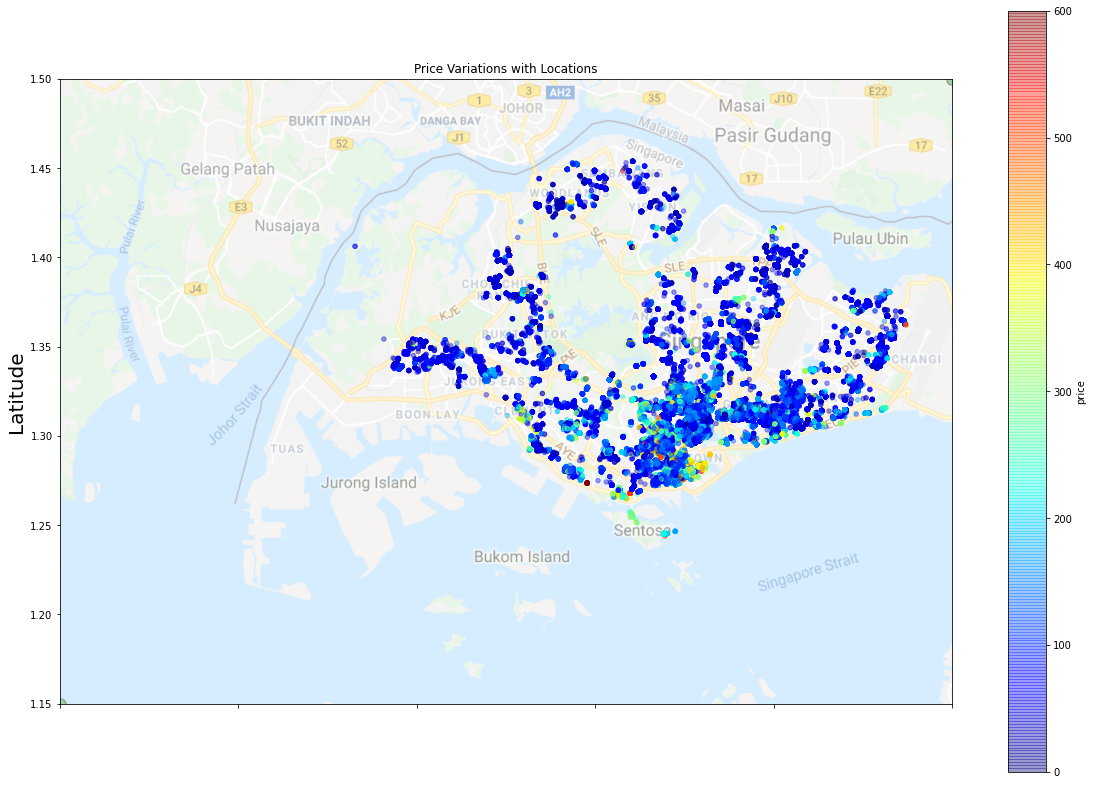

In [162]:
# Plot the relation of prices with geolocations
plotmap(df_cut, 'price')

In [163]:
shapefile = '../Pictures/2014-planning-area/MP14_PLNG_AREA_NO_SEA_PL.shp'
map_nbr = gpd.read_file(shapefile)

In [202]:
df_price_map = df_price_nbr.reset_index()
df_price_map.neighbourhood_cleansed = df_price_map.neighbourhood_cleansed.str.upper()

merge_map = map_nbr.merge(df_price_map, left_on='PLN_AREA_N', right_on='neighbourhood_cleansed')
merge_map.reset_index(inplace=True)

In [203]:
merge_map

,index,OBJECTID,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,...,neighbourhood_cleansed,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,0,1,ANG MO KIO,AM,N,NORTH-EAST REGION,NER,E5CBDDE0C2113055,2016-05-11,28976.8763,...,ANG MO KIO,83.254325,0.684850,93.441901,9.580986,9.392606,9.938272,9.931338,9.035336,9.340388
1,1,2,BEDOK,BD,N,EAST REGION,ER,1719251260799DF6,2016-05-11,38582.6650,...,BEDOK,101.185028,0.674384,94.217740,9.666925,9.548358,9.795190,9.793121,9.364930,9.411742
2,2,3,BISHAN,BS,N,CENTRAL REGION,CR,BA616285F402846F,2016-05-11,28789.7630,...,BISHAN,77.375276,0.647420,92.489433,9.450501,9.230256,9.705228,9.666296,9.219132,9.317019
3,3,5,BUKIT BATOK,BK,N,WEST REGION,WR,FB44C870B04B7F57,2016-05-11,19255.4150,...,BUKIT BATOK,73.005806,0.648054,92.387427,9.432749,9.362573,9.687683,9.796784,9.060117,9.256598
4,4,6,BUKIT MERAH,BM,N,CENTRAL REGION,CR,738B479882E4EE28,2016-05-11,26865.7838,...,BUKIT MERAH,146.304147,0.656271,92.660471,9.557156,9.340458,9.720880,9.663259,9.506815,9.199969
5,5,7,BUKIT PANJANG,BP,N,WEST REGION,WR,4A9C6E6BAF7BE998,2016-05-11,21287.0436,...,BUKIT PANJANG,118.159744,0.661394,90.508039,9.302251,9.147910,9.424437,9.604502,8.982315,9.163987
6,6,8,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,C893AEAD20F42559,2016-05-11,23256.7643,...,BUKIT TIMAH,89.481157,0.687605,92.716865,9.507272,9.272127,9.711767,9.758925,9.228735,9.329661
7,7,9,GEYLANG,GL,N,CENTRAL REGION,CR,957AC76DACFDE12E,2016-05-11,34255.0407,...,GEYLANG,120.127447,0.626691,91.254117,9.413392,9.138233,9.642328,9.665331,9.040908,9.111832
8,8,10,KALLANG,KL,N,CENTRAL REGION,CR,229F1481FF686959,2016-05-11,31685.3730,...,KALLANG,121.288386,0.617987,91.037026,9.375148,9.050885,9.627004,9.610773,9.369183,9.061883
9,9,11,NOVENA,NV,N,CENTRAL REGION,CR,916F55DE440B0D0E,2016-05-11,28221.5058,...,NOVENA,156.568684,0.614884,91.689624,9.311941,9.138805,9.568654,9.526699,9.272341,9.063126


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

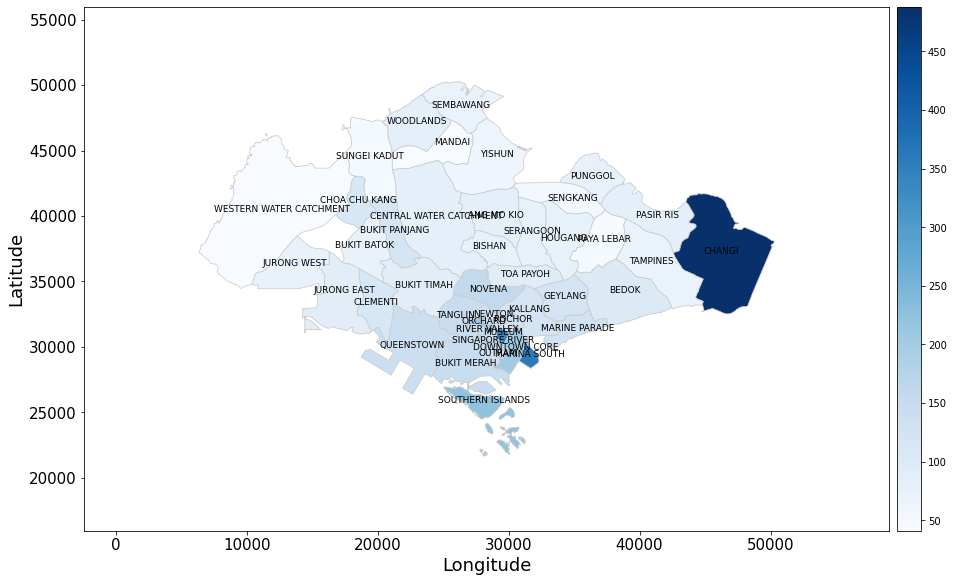

In [219]:
# Plot the map
fig, ax = plt.subplots(1, figsize = (15,25))

merge_map['coords'] = merge_map['geometry'].apply(lambda x:x.representative_point().coords[:])
merge_map['coords'] = [coords[0] for coords in merge_map['coords']]

for idx, row in merge_map.iterrows():
    plt.annotate(s=row['PLN_AREA_N'], xy=row['coords'], horizontalalignment='center',fontsize=9)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.1)

ax.margins(0.2,0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

merge_map.plot(column='price',ax=ax,legend=True,cax=cax,cmap='Blues',linewidth=0.8,edgecolor='0.8')

